# Introdução ao oneAPI e OpenMP* Offload com C/C++

### Pré-requisitos
Este curso pressupõe conhecimento geral de OpenMP para CPUs. Se você é novo no OpenMP, abaixo estão alguns ótimos recursos para você começar.
* [Curso Básico de OpenMP](https://www.youtube.com/watch?v=nE-xN4Bf8XI&list=PLLX-Q6B8xqZ8n8bwjGdzBJ25X2utwnoEG)
* [Especificação OpenMP (para versão 5.0)](https://www.openmp.org/wp-content/uploads/OpenMP-API-Specification-5.0.pdf)

### Avisos Prévios
* Altere o `Runtime` para GPU's antes de iniciar este Jupyter.
* Execute as células abaixo para baixar a ultima versão de OpenMP, caso esteja no Google Colab.


In [ ]:
#Download openMP libs & gcc & svn 
!true | add-apt-repository ppa:ubuntu-toolchain-r/test 
!apt install gcc-11 g++-11 g++-11-multilib gcc-11-offload-nvptx libgomp1 libomp-dev
!sudo apt-get install subversion
#Link latest version of CUDA on Colab Session
!ln -sfnv /usr/local/cuda-11 /usr/local/cuda

#Copy main files from menotti/pp/.../ lab & img
#Using svn package
!svn checkout https://github.com/menotti/pp/trunk/code/OpenMP/img
!svn checkout https://github.com/menotti/pp/trunk/code/OpenMP/lab

In [32]:
#Esta celula confirma se realmente foram instalados...
!whereis gcc-11
!whereis cuda-11
!gcc-11 --version

# Output esperado:
# gcc-11: /usr/bin/gcc-11 /usr/share/man/man1/gcc-11.1.gz
# cuda-11: /usr/local/cuda-11 /usr/local/cuda-11.2

gcc-11: /usr/bin/gcc-11 /usr/share/man/man1/gcc-11.1.gz
cuda-11: /usr/local/cuda-11.2 /usr/local/cuda-11
gcc-11 (Ubuntu 11.1.0-1ubuntu1~20.04) 11.1.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



## Visão geral do modelo de software oneAPI
O modelo de software oneAPI fornece um portfólio abrangente e unificado de ferramentas de desenvolvedor que podem ser usados com ênfase no hardware, incluindo uma variedade de bibliotecas de desempenho, abrangendo vários tipos de trabalhos. As bibliotecas incluem funções codificadas de forma personalizada para cada arquitetura de destino, de modo que a mesma
chamada de função oferece desempenho otimizado em arquiteturas suportadas. A iniciativa oneAPI é baseada em __padrões da indústria e especificações abertas__ e é interoperável com os modelos de programação HPC existentes.

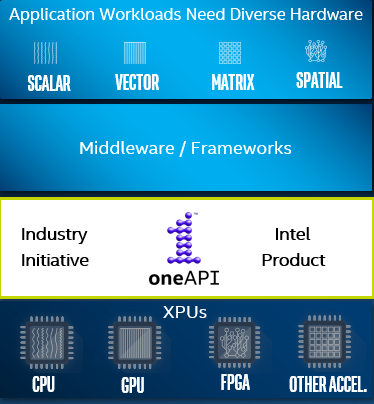


## Fluxo de trabalho de nó único HPC com oneAPI
O código acelerado pode ser escrito no estilo kernel (SYCL) ou __directive-based__ (OpenMP). Os desenvolvedores __CUDA*__ podem usar a __Intel® DPC++ Compatibility tool__ para realizar uma migração única de __CUDA*__ para __SYCL__. Os aplicativos __Fortran__ e C existentes podem usar construções de descarregamento do OpenMP __offload__. Os aplicativos __C++__ existentes podem escolher o estilo __Kernel__ ou a __opção de estilo baseado em diretiva__ e os aplicativos __OpenCL__ existentes podem permanecer na linguagem OpenCL ou migrar para SYCL.

__Intel® Advisor__ é recomendado para __Otimizar__ o design para __vetorização e memória__ (CPU e GPU) e __Identificar__ loops candidatos a __offload__ e projetar o __desempenho nos aceleradores de destino.__

A figura abaixo mostra a abordagem recomendada de diferentes pontos de partida para desenvolvedores de HPC:


<!-- <img src="img/workflow.png"> -->


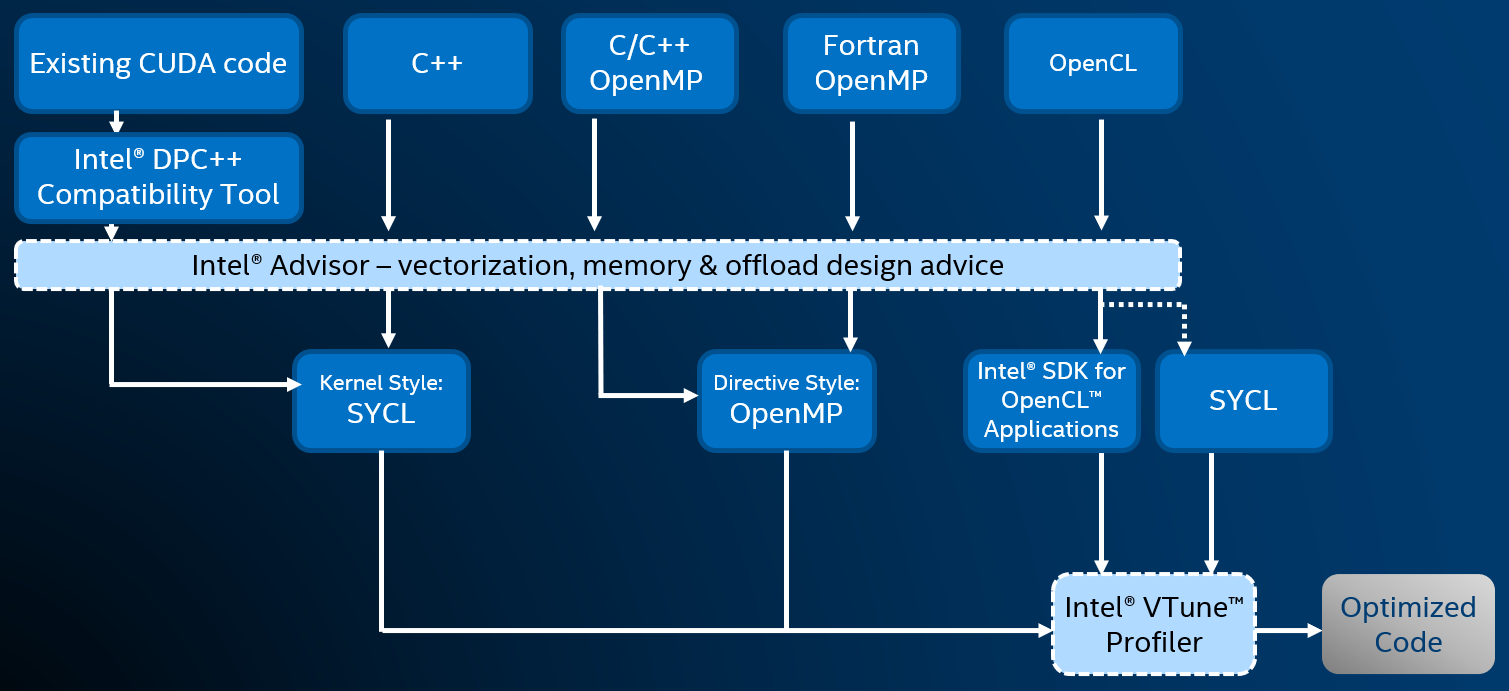


## OpenMP x SYCL
Ambos, OpenMP e SYCL, são padrões abertos que podem ser usados para acelerar algoritmos em GPUs. Como mostra o diagrama de fluxo de trabalho, o oneAPI oferece suporte a ambas as metodologias e você deve conseguir obter um desempenho otimizado semelhante com qualquer uma das opções. A decisão entre as duas opções provavelmente depende dos requisitos do fluxo de trabalho e da facilidade de portabilidade. Ao migrar de projetos __CUDA__ ou __OpenCL__ existentes, o SYCL provavelmente faria mais sentido. Ao migrar de aplicativos C/Fortran existentes com __OpenMP__, o descarregamento do OpenMP seria a alternativa mais fácil.

## Descarregamento do OpenMP
Construções **OpenMP Offload** são um conjunto de diretivas para C++ e Fortran introduzidas no OpenMP 4.0 e aprimoradas ainda mais em versões posteriores que permitem aos desenvolvedores descarregar dados e execução para aceleradores de destino, como GPUs. O descarregamento do OpenMP é suportado no Intel® oneAPI HPC Toolkit com o Intel® C++ Compiler e o Intel® Fortran Compiler.

***
## Exercício Simples
Este exercício apresenta o OpenMP __Offload__ ao desenvolvedor por meio de um pequeno código simples. Além disso, apresenta ao desenvolvedor o ambiente de notebook Jupyter para edição e salvamento de código; e para executar e enviar programas para o Intel® oneAPI DevCloud.

Começamos com um programa que inclui construções OpenMP básicas, incluindo *parallel* e *for*. Em seguida, adicionaremos a diretiva *target* para descarregar parte do programa no dispositivo GPU.

Este programa simples percorre todos os elementos da matriz de dados e os multiplica por 2.

### Editando o código simple.cpp
A célula Jupyter abaixo com o plano de fundo cinza pode ser editada no local e salva.

A primeira linha da célula contém o comando **%%writefile 'simple.cpp'** Isso diz à célula de entrada para salvar o conteúdo da célula no nome do arquivo 'simple.cpp' À medida que você edita a célula e a executa , ele salvará suas alterações nesse arquivo.
O código abaixo mostra o código OpenMP simples. Inspecione o código, não há modificações necessárias:
1. Inspecione a célula de código abaixo e clique em executar ▶ para salvar o código no arquivo
2. Em seguida, execute ▶ a célula na seção __Build and Run__ abaixo do código para compilar e executar o código.

In [43]:
%%writefile lab/simple.cpp
#include <omp.h>
#include <iostream>

constexpr int N = 1<<30;

int main() {
  int is_cpu;
  int *data = static_cast<int *>(malloc(N * sizeof(int)));

  // Initialization
  for (int i = 0; i < N; i++) 
    data[i] = i;
  {
    is_cpu = omp_is_initial_device();
    // Use OpenMP to Parallelize Algorithm
    #pragma omp parallel for
    for (int i = 0; i < N; i++) {
      data[i] *= 2;
    }
  }

  // Print Output
  std::cout << "Running on " << (is_cpu ? "CPU" : "GPU") << "\n";
//  for (int i = 0; i < N; i++) 
//    std::cout << data[i] << "\n";

  free(data);
  return 0;
}

Overwriting lab/simple.cpp


In [44]:
!/usr/bin/gcc-11 lab/simple.cpp -lstdc++ -fopenmp -o simple && time ./simple

tcmalloc: large alloc 4294967296 bytes == 0x55bd61186000 @  0x7f6e30fb2680 0x7f6e30fd3824 0x55bd5f878296 0x7f6e30b51083 0x55bd5f8781ae
Running on CPU

real	0m6.710s
user	0m6.634s
sys	0m1.790s


## Diretiva `target`
A construção `omp target` transfere o controle e os dados do host para o dispositivo. A transferência de controle é sequencial e síncrona. Em um ambiente de vários dispositivos, a cláusula _device_ pode ser opcionalmente usada para denotar um dispositivo específico. Cada dispositivo recebe um número inteiro específico da implementação. Cláusulas `map` podem ser usadas para controlar a direção do fluxo de dados. As cláusulas `map` serão discutidas em detalhes no próximo módulo.

Exemplo - target:
```c
...// Código Sequencial do Host

#pragma omp target //Região de destino executada no dispositivo
{
     for (...) {
         ...;
     }
}
...// Mais código de host sequencial
```
Em alguns casos, podemos ter mais de um device com alvo para envio de dados para paralelização. Neste caso, a biblioteca de OpenMP também disponibiliza a opção de escolha para envio de dados para paralelização.

Exemplo - device: 

```c
...// Código Sequencial do Host

int N_GPU = 1;
#pragma omp target device(N_GPU)
//Região de destino executada no device selecionado
{
     for (...) {
         ...;
     }
}
...// Mais código de host sequencial
```



## Definindo o dispositivo de destino para depuração
Definir a variável de ambiente `OMP_TARGET_OFFLOAD` especifica em qual código de região de destino do dispositivo deve ser executado. Isso permite que o usuário depure o código de área de destino sem modificações.
```shell
export OMP_TARGET_OFFLOAD={"MANDATÓRIO" | "DESATIVADO" | "PADRÃO" }
```
* `MANDATORY`: O código da região de destino em execução em uma GPU ou acelerador.
* `DISABLED`: O código da região alvo rodando em uma CPU.
* `DEFAULT`: O código da região de destino em execução em uma GPU, se o dispositivo estiver disponível, se não estiver, retornará à CPU.

Por padrão, `OMP_TARGET_OFFLOAD` é definido como `DEFAULT`.

Por exemplo, executar o seguinte comando antes de um programa OpenMP exigirá que o programa execute o código da região de destino em uma CPU.
```shell
export OMP_TARGET_OFFLOAD="DISABLED"
```

## Executando um programa OpenMP com a diretiva Target
No exemplo abaixo, adicione a diretiva `#pragma omp target map(from:is_cpu) map(tofrom:data[0:N])` onde indicado para descarregar a execução para a GPU. Usamos as cláusulas map aqui para transferir *dados* de e para a GPU enquanto também copiamos o valor de *is_cpu* de volta para o host para ver se nosso código realmente foi executado na GPU. A cláusula map será discutida em detalhes no próximo módulo.

In [45]:
%%writefile lab/simple_target.cpp
#include <iostream>
#include <omp.h>

constexpr int N = 1<<30;

int main() {
  int is_cpu = true;
  int *data = static_cast<int *>(malloc(N * sizeof(int)));

  int num_devices = omp_get_num_devices();
  printf("Numero de Dispositivos Disponiveis: %d\n", num_devices);

  // Inicialização do Vetor
  for (int i = 0; i < N; i++) 
    data[i] = i;

  #pragma omp target map(from: is_cpu) map(tofrom: data[0:N])
  {
    is_cpu = omp_is_initial_device();
    #pragma omp parallel for
    for (int i = 0; i < N; i++) {
      data[i] *= 2;
    }
  }
  // Print Output
  std::cout << "Execução em " << (is_cpu ? "CPU" : "GPU") << "\n";
//  for (int i = 0; i < N; i++) 
///    std::cout << data[i] << "\n";

  free(data);
  return 0;
}

Overwriting lab/simple_target.cpp


### Execução em GPU Nvidia(Google Colab)

In [46]:
!/usr/bin/gcc-11 lab/simple_target.cpp -fcf-protection=none -fno-stack-protector -lstdc++ -fopenmp -o simple_target && time ./simple_target

tcmalloc: large alloc 4294967296 bytes == 0x559faaf30000 @  0x7f9b541ab680 0x7f9b541cc824 0x559faa42322a 0x7f9b53d4a083 0x559faa42314e
Numero de Dispositivos Disponiveis: 1
Execução em GPU

real	0m24.504s
user	0m21.871s
sys	0m2.544s


# Transferencias de dados para dispositivos com opemMP

## Descarregamento de dados
O host e os dispositivos têm espaços de memória separados, portanto, quando partes do código são descarregadas, os dados precisam ser mapeados para o dispositivo de destino para serem acessados dentro da região de destino.

Por padrão, as variáveis acessadas dentro da região de destino são tratadas da seguinte forma:

|Tipo | Comportamento |
|:----:|:----|
|Escalares | Tratado como `firstprivate` |
|Arrays estáticos | Copiado para o dispositivo na entrada e do dispositivo para o host na saída |
|Arrays dinâmicos | Igual ao anterior, o comprimento deve ser especificado |

No exemplo a seguir, o compilador identificará todas as variáveis usadas na região de destino (a, x e y) e os dados serão transferidos para o dispositivo com base nas regras acima.

```c
void saxpy() {
     float a, x[ARRAY_SIZE], y[ARRAY_SIZE];
     #pragma omp target
     // Na entrada da região de destino, a, x e y copiados do host para o dispositivo
     for (int i=0; i< ARRAY_SIZE; i++) {
         y[i] = a * x[i] + y[i];
     }
     // Ao sair da região de destino, x e y são copiados de volta para o host,
     // mesmo que x não tenha sido alterado.
}
```


## Cláusula `map`

Para eliminar cópias de dados desnecessárias, use a cláusula `map` da diretiva `target` para mapear manualmente as variáveis para o ambiente de dados do dispositivo.
```c
#pragma omp target map(<tipo de map>: variável)
```
Os *tipos de map* disponíveis são
* `alloc`: Aloca armazenamento para variável no dispositivo de destino, valores não copiados
* `to`: Aloca armazenamento no dispositivo de destino e atribui valor **da variável do host original ao dispositivo** na entrada da região de destino
* `from`: Aloca armazenamento no dispositivo de destino e atribui valor **do dispositivo à variável do host original** na saída da região de destino
* `tofrom`: padrão, união de  `to` e `from`


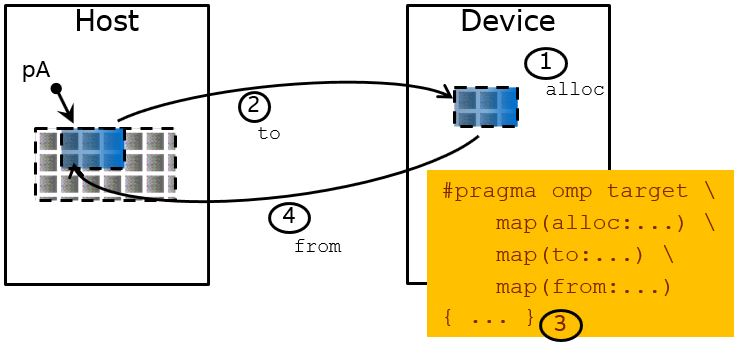

## Exercício: Usos da diretiva `map`

Neste exercício, você adicionará uma cláusula map à operação saxpy ($y=ax+y$). O arquivo de origem principal, main.cpp, foi escrito para você. Ele inclui saxpy_func.cpp que você preencherá e gravará no arquivo neste bloco de notas Jupyter. Se você gostaria de ver o conteúdo de main.cpp, execute a seguinte célula.

In [47]:
#Opcional,visualização dos dados de main_saxpy.cpp
%pycat lab/main_saxpy.cpp

Na célula abaixo, adicione a cláusula map que mapearia a matriz x para o destino para que ela não fosse copiada de volta desnecessariamente. Além disso, adicione a cláusula `map(from:is_cpu)` para sabermos se o código foi executado na GPU.

In [48]:
%%writefile lab/saxpy_func.cpp
// #TODO: Adicione uma das diretivas de openMP com uso de map
#pragma 
{
  is_cpu = omp_is_initial_device();
  for (i = 0; i < ARRAY_SIZE; i++) {
    y[i] = a * x[i] + y[i];
  }
}


Writing lab/saxpy_func.cpp


Na célula abaixo, adicione a cláusula map que mapearia a matriz x para o destino para que ela não fosse copiada de volta desnecessariamente. Além disso, adicione a cláusula `map(from:is_cpu)` para sabermos se o código foi executado na GPU.

### Compilar e executar o código
Em seguida, compile e execute o código por meio da célula abaixo.

In [60]:
!/usr/bin/gcc-11 lab/main_saxpy.cpp -fcf-protection=none -fno-stack-protector -lstdc++ -fopenmp -o main_saxpy && ./main_saxpy

Work took 0.045292 seconds
Running on CPU.
Test: PASSED!


## Especificação de comprimento e dados alocados dinamicamente

Para arrays alocados dinamicamente, ao usar a construção `target map`, o número de elementos a serem mapeados deve ser explicitamente especificado. Arrays parciais podem ser especificadas.
```c
#pragma omp target map(to:array[start:length])
```
No exemplo anterior, x e y são Arrays estáticas, portanto, a especificação do comprimento é opcional. Se desejar, você pode voltar ao exemplo anterior **e especificar o tamanho do Array a ser mapeado**.

## Região de dados de destino -- target data
Quando há mais de uma região de destino, geralmente é útil criar uma região de **dados** de destino maior que englobe todas as regiões de destino para minimizar a cópia de dados nas regiões de destino. Existem duas maneiras de criar uma região de dados de destino, usando `target data` ou usando `target enter data` e `target exit data`.
### Dados de destino
A construção `target data` cria um ambiente de dados com escopo e mapeia dados de e para o dispositivo. Ao usar esta construção, os tipos de mapa `alloc`, `to`, `from` e `tofrom` estão disponíveis.

Observação: `Target Data` não cria uma região de destino que descarrega a execução. Construções `target` dentro do ambiente de dados são necessárias para realizar isso.




```cpp

//Incialização da paralelização..
#pragma omp target data map(tofrom: x)
  {
// Ambiente de dados do dispositivo criado, x permanece no dispositivo durante as duas regiões de destino
  #pragma omp target(to: y)
    {
    // Primeira região alvo
    }

    //OBS: Esta parte é executada em host(local)
    host_update(s); 
    
    #pragma omp target(to: y)
    {
    // Segunda região alvo
    }
  }
```



### Target Enter/Exit Data e Update
As construções `target enter/exit data` podem ser usadas para marcar explicitamente o início e o fim do ambiente de dados de destino.

Ao usar a construção `target enter data`, apenas os tipos de mapa de `alloc` e `to` estão disponíveis. Ao usar a construção `target exit data`, os tipos de mapa `from`, `release` e `delete` estão disponíveis.

A construção `target update` é usada para emitir transferências de dados para ou do ambiente de dispositivo de dados existente.

Observação: as construções `target enter/exit/update data` não têm escopo e não descarregam a execução do código. As construções `target` são necessárias entre a entrada e a saída do ambiente de dados para realizar isso.

Exemplo:
```c
#pragma omp target enter data \
                map(to:y) map(alloc: x)

  #pragma omp target
  { 
    //Primeira região, operações do dispositivo em x e y
  }
  #pragma omp target update from(y)
  //Atualiza para executar local
  host_update(s);
  #pragma omp target update to(y)

  #pragma omp target
  { 
    //2ª região, operações do dispositivo em x e y
  }
#pragma omp target exit date map(from:x)
```

## Exercício: região de dados de destino
Neste exercício, temos duas regiões-alvo. x e y são matrizes estáticas de tamanho ARRAY_SIZE e são usadas nas regiões de destino. Além disso, o valor de y é atualizado pelo host entre as regiões. Para este programa, *main_data_region.cpp* contém main e inclui *target_data_region.cpp*, que é o arquivo que você substituirá.

Crie um ambiente de dados de destino que englobe ambas as regiões de destino, certifique-se de que `x` permaneça no dispositivo em toda a região e certifique-se de que `y` seja atualizado no dispositivo após a chamada do host `init2`. Teste seu código e certifique-se de que a mensagem PASSED seja exibida.

Existem duas maneiras de resolver esse problema. Você pode optar por usar `target data` ou `target enter/update/exit data`. A solução é fornecida para ambos.

In [62]:
#Opcional: Examine main_data_region.cpp se quiser.
%pycat lab/main_data_region.cpp

In [64]:
%%writefile lab/target_data_region.cpp
//# Aqui temos 2 maneiras de fazer:declaração implicita ou com enter/exit data
#pragma omp target(...)
{
  #pragma omp target (...)
    {
      for (int i = 0; i < ARRAY_SIZE; i++) x[i] += y[i];
      printf("Valor x: %.2f\n", x[2]);
    }

    init2(y, ARRAY_SIZE);

  #pragma omp target (...)
    {
      for (int i = 0; i < ARRAY_SIZE; i++) x[i] += y[i];
      printf("Valor x: %.2f\n", x[2]);
    }
    printf("Valor x: %.2f\n", x[2]);
}
// ... (...) ?

Writing lab/target_data_region.cpp


### Compilar e executar o código
Em seguida, compile e execute o código usando *run.sh*. Se você gostaria de ver o conteúdo de run.sh, execute a seguinte célula.

In [ ]:
!/usr/bin/gcc-11 lab/main_data_region.cpp -fcf-protection=none -fno-stack-protector -lstdc++ -fopenmp -o main_data_region && ./main_data_region

### Resposta(s) para o exercício

__(Aqui, disponibilizaremos uma das respostas na célula logo abaixo)__

**Versão de Declaração Explícita**
```cpp
#pragma omp target enter data map(to : x) map(to : y)
  #pragma omp target
  {
    for (int i = 0; i < ARRAY_SIZE; i++) x[i] += y[i];
  }

  init2(y, ARRAY_SIZE);

  #pragma omp target update to(y)

  #pragma omp target
  {
    for (int i = 0; i < ARRAY_SIZE; i++) x[i] += y[i];
  }
#pragma omp target exit data map(from : x)

```

## Mapeamento de Variáveis Globais para o Dispositivo
Com o OpenMP, você também tem a opção de mapear uma variável para o dispositivo durante o programa. Use a diretiva `declare target` para especificar que variáveis e funções são mapeadas para um dispositivo. Aqui está um exemplo.

```c
#pragma omp declare target
int a[N]
#pragma omp end declare target

//Código do host
inicial(a);

#pragma omp target
for (int i=0; i<N; i++) {
     resultado[i]=processo(a[i]);
}
```

***

# Paralelismo em dispositivo (C/C++)
## Paralelismo de dispositivos
Conforme discutimos nos módulos anteriores, a construção `target` do OpenMP transfere o fluxo de controle para o dispositivo de destino. No entanto, a transferência de controle é sequencial e síncrona.

No OpenMP, offload e paralelismo são separados, então os programadores precisam criar explicitamente regiões paralelas no dispositivo de destino. Em teoria, construções que criam paralelismo em dispositivos offload podem ser combinadas com qualquer construção OpenMP, mas, na prática, apenas um subconjunto de construções OpenMP é útil para o dispositivo de destino.



## Arquitetura da GPU
Antes de mergulhar nas construções de paralelismo OpenMP para dispositivos de destino, vamos primeiro examinar a arquitetura da GPU Intel®.


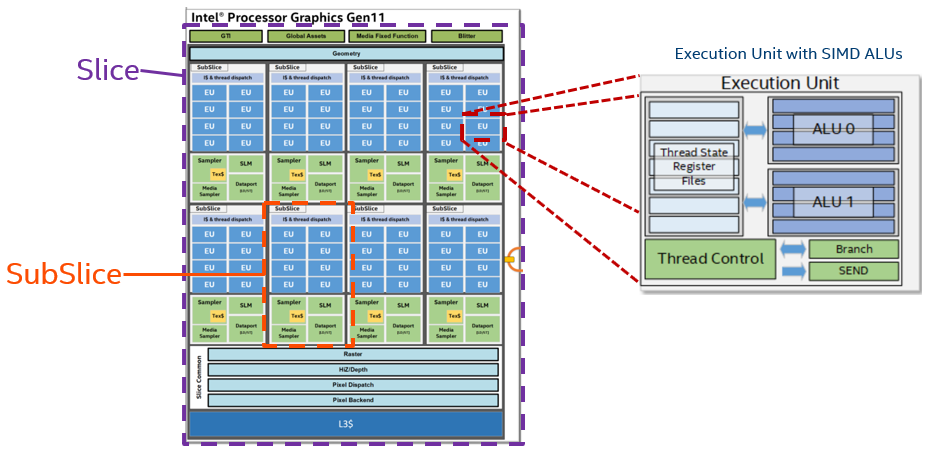

As GPUs Intel® contêm 1 ou mais fatias. Cada fatia é composta por várias subfatias (também chamadas de núcleos de GPU). Cada subfatia contém vários EUs (provavelmente 8 ou mais), possui sua própria unidade de despacho de encadeamento, cache de instruções, memória local compartilhada e outros recursos. EUs são processadores de computação que dirigem os SIMD ALUs.

A tabela a seguir mostra como os conceitos OpenMP de League, Team, Thread e SIMD são mapeados para hardware GPU.

|OpenMP | hardware da GPU |
|:----:|:----|
|SIMD | SIMD (Canal) |
|Thread | SIMD Thread mapeado para uma Unidade de Execução(UE) |
|Team | Grupo de threads mapeados para uma subfatia |
|League | Várias threads mapeadas para uma GPU |

## Construções OpenMP "normais"
O descarregamento da GPU OpenMP suporta todas as construções OpenMP "normais", como `parallel`, `for`, `barrier`, `sections`, `tasks`, etc. No entanto, nem todas as construções serão úteis para a GPU. Ao usar essas construções, o modelo de encadeamento completo é suportado apenas em uma subfatia, porque não há sincronização entre as subfatias e não há coerência e cerca de memória entre os caches L1 das subfatias.

Vamos examinar o seguinte exemplo.
```c
void saxpy(float a, float* x, float* y, int sz) {
     #pragma omp target map(to:x[0:sz]) map(tofrom(y[0:sz])
     #pragma omp parallel for simd
     for (int i=0; i< sz; i++) {
         y[i] = a * x[i] + y[i];
     }
}
```
Aqui, usamos o pragma `target` para descarregar a execução para a GPU. Em seguida, usamos `parallel` para criar uma equipe(team) de threads, `for` para distribuir iterações de loop para esses threads e `simd` para solicitar a vetorização de iteração com instruções SIMD. No entanto, devido às restrições mencionadas, apenas um subfatia de GPU é utilizado aqui, portanto, a GPU seria significativamente subutilizada. Em alguns casos, o compilador pode deduzir `team distribute` de `parallel for` e ainda usar toda a GPU.

## Liga de Equipes(Teams)
Para aproveitar várias subfatias, use o pragma `teams` para criar várias threads **mestres** para execução. Quando combinados com o pragma `parallel`, esses threads mestres se tornam uma liga de equipes(teams) de threads. Como não há sincronização entre equipes de threads, as equipes podem ser atribuídas a diferentes subfatias da GPU.
<!-- 
<img src="img/teams.jpeg"> -->


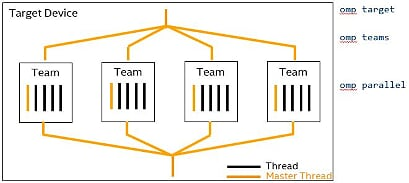


Ao usar a construção `teams`, o número de equipes criadas é definido pela implementação. No entanto, você pode opcionalmente especificar um limite superior com a cláusula **num_teams**. A cláusula **thread_limit** do pragma `teams` pode ser opcionalmente usada para limitar o número de threads em cada equipe.

Exemplo: `#pragma omp teams num_teams(8) thread_limit(16)`

## Compartilhamento de trabalho com equipes
Depois que uma liga de times é criada por `teams`, use a construção `distribute` para distribuir blocos de iterações de um loop entre os diferentes times da liga. Isso é análogo ao que a construção `for` faz para regiões `paralelas`. O pragma `distribute` está associado a um ninho de loop dentro de uma região de equipes.

Para loops aninhados, a cláusula **collapse** pode ser usada para especificar quantos loops estão associados ao pragma `distribute`. Você pode especificar uma cláusula **collapse** com um valor de parâmetro maior que 1 para recolher os loops associados em um loop grande.

Você também pode usar a cláusula **dist_schedule** na construção `distribute` para especificar manualmente o tamanho do bloco que é distribuído para os threads principais de cada equipe. Por exemplo, `#pragma omp distribute dist_schedule(static, 512)` criaria pedaços de 512 iterações.

### Exemplo com construções combinadas
Por conveniência, o OpenMP oferece suporte a construções combinadas para descarregamento do OpenMP. O código abaixo mostra como uma única linha pode abranger todos os pragmas que discutimos.
```c
void saxpy (float a, float *x, float *y, int sz) {
     #pragma omp teams distribute parallel for simd \
                map(to:x[0:sz]) map(tofrom(y[0:sz])
     for (int i=0; i<sz; i++) {
         y[i] = a*x[i] + y[i];
     }
}
```
Quando essas construções são usadas sem cláusulas adicionais, o número de equipes criadas, o número de encadeamentos criados por equipe e como as iterações de loop são distribuídas são todos definidos pela implementação.
O diagrama a seguir detalha os efeitos de cada pragma no exemplo anterior. Aqui, assumimos que há um total de 128 iterações de loop e que 4 times e 4 threads por time são criados pela implementação.

1. O pragma `omp target` descarrega a execução para o dispositivo
2. O pragma `omp teams` cria vários threads mestres, 4 equipes de threads neste diagrama.
3. O pragma `omp distribute` distribui iterações de loop para essas 4 equipes de threads, 32 threads para cada equipe mostrada.
4. O pragma `omp parallel` cria um time de threads para cada thread master (team), 4 threads criadas para cada time mostrado.
5. O pragma `omp for` distribui as 32 iterações para cada uma das 4 threads.
6. O pragma `omp simd` especifica que múltiplas iterações do loop podem ser executadas usando instruções SIMD.

OBS: por analogia, existem semelhanças quando trabalhamos com CUDA: `Teams` equivale ao Nro. de blocos.
<!-- 
<img src="img/distribute.jpeg"> -->


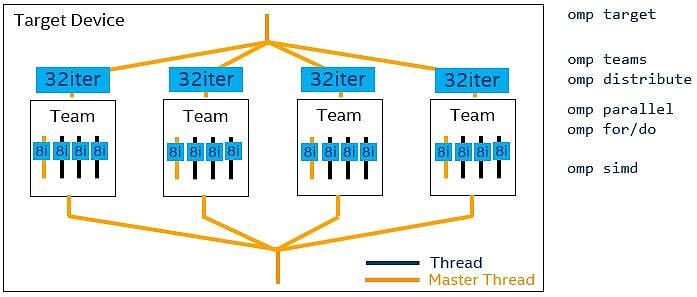

## Dispositivo host e Concorrência

Quando uma região de destino é encontrada, uma tarefa de host é gerada, sincronizando a CPU e o dispositivo de destino. O OpenMP usa tarefas para gerenciar a execução e as dependências. Adicione a cláusula `nowait` para que o host não precise esperar que a região de destino seja concluída.

```c
#pragma omp target nowait
```

O uso de uma cláusula `nowait` com uma construção `target` permite o descarregamento assíncrono, permitindo que o dispositivo host continue a execução. Uma maneira de sincronizar uma região de destino com o dispositivo host é usando a construção `taskwait`, que aguardará até que todas as tarefas sejam concluídas.

No exemplo a seguir, o loop for é transferido para o dispositivo de destino, enquanto o dispositivo host continua a execução e realiza outros trabalhos. Após a conclusão do dispositivo e do host, o dispositivo host continuará a execução.

```c
#pragma omp target map(to:b,c,d) map(from:a) nowait
{
     #pragma omp teams distribute parallel for simd
     for (i=0; i<500; i++) {
         a[i] = b[i] * c + d;
     }
}

#pragma  omp task
     outro trabalho();

#pragma omp taskwait //Sincronização
     a0 = a[0];
```

## Exercício: Paralelismo de dispositivos OpenMP
Neste exercício, praticaremos o uso das construções de compartilhamento de trabalho offload na função saxpy com a qual já trabalhamos nos módulos anteriores.

Na célula abaixo, adicione pragmas OpenMP nos locais indicados para executar as seguintes tarefas.
1. Para o loop externo, use uma construção **combinada** para
     1. Crie NUM_BLOCKS de threads **master**, use a cláusula *num_teams(NUM_BLOCKS)*
     2. Distribua as iterações do loop externo para os threads principais varoius.
2. Para o loop interno, use uma construção combinada para
     1. Crie uma equipe de encadeamentos para cada encadeamento principal.
     2. Distribua as iterações do loop interno para esses threads.
     3. Sinal de que várias iterações de loop podem ser executadas simultaneamente com instruções SIMD.

In [71]:
%%writefile lab/saxpy_func_parallel.cpp
#pragma omp target map(from: is_cpu) map(from:num_teams) map(to:x[0:ARRAY_SIZE]) map(tofrom:y[0:ARRAY_SIZE])
{

  // 1. Inclua pragma para criar multiplas threads master --> use num_treads(NUM_BLOCKS)
  //    e distribua as iterações dos loop para as threads masters. 

  for (ib = 0; ib < ARRAY_SIZE; ib += NUM_BLOCKS) {
    if (ib == 0) {

      //teste de verificação se estamos no Host ou Device..
      is_cpu = omp_is_initial_device();
      
      // obtem o numero de times criados
      num_teams = omp_get_num_teams();
    }

    // 2. Coloque a combinação no pragma para criar o time de threads para
    // cada thread master, distribuindo estas threads e vetorizando.
    
    for (i = ib; i < ib + NUM_BLOCKS; i++) {
      y[i] = a * x[i] + y[i];
    }
  }
}

Overwriting lab/saxpy_func_parallel.cpp


In [ ]:
!/usr/bin/gcc-11 lab/main_saxpy_parallel.cpp -fcf-protection=none -lm -fno-stack-protector -lstdc++ -fopenmp -o main_saxpy_parallel && ./main_saxpy_parallel